In [23]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from torch.utils.tensorboard import SummaryWriter
import os

os.chdir("/home/andrei/Desktop/PROJECT_ELLIS_COMDO/FOLDER_code")
import time
import comdo
import pickle
import copy

In [24]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x




def loss(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)


def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)




# Step 1
Make sure vanilla SGD from crossed setup similar convergence curves to your SGD implementation

In [25]:
BATCH_SIZE = 64
LEARNING_RATE = 0.005
STEPS = 150
PRINT_EVERY = 10

In [38]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

# ____________________ splitting MNIST into 2 distinct datasets __________________
import os
os.chdir("/home/andrei/Desktop/PROJECT_ELLIS_COMDO/FOLDER_code")

from comdo.utils_ANNs import get_2DO_datasets


Agent1_Train_dataset, Agent1_Test_dataset, Agent2_Train_dataset, Agent2_Test_dataset = \
    get_2DO_datasets(train_dataset= train_dataset, test_dataset= test_dataset)


trainloader_Agent1 = torch.utils.data.DataLoader(
    Agent1_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader_Agent1 = torch.utils.data.DataLoader(
    Agent1_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

trainloader_Agent2 = torch.utils.data.DataLoader(
    Agent2_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader_Agent2 = torch.utils.data.DataLoader(
    Agent2_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

list_test_Accuracies_acrossInitializations = []
list_test_Loss_acrossInitializations = []


In [39]:
def train(
    optim1,
    optim2,
    models: CNN,
    trainloader_Agent1: torch.utils.data.DataLoader,
    trainloader_Agent2: torch.utils.data.DataLoader,
    testloader_Agent1: torch.utils.data.DataLoader,
    testloader_Agent2: torch.utils.data.DataLoader,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    # opt_state = optim.init(eqx.filter(model, eqx.is_array))



    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.

    opt_state1 = optim1.init(eqx.filter(models[0], eqx.is_array))
    opt_state2 = optim2.init(eqx.filter(models[1], eqx.is_array))


    # @eqx.filter_jit # TODO: comment if breaks
    def make_step(
        models: CNN,
        opt_state1: PyTree,
        opt_state2: PyTree,
        x_agent1: Float[Array, "batch 1 28 28"],
        y_agent1: Int[Array, " batch"],
        x_agent2: Float[Array, "batch 1 28 28"],
        y_agent2: Int[Array, " batch"],

    ):

        # making list with the grads (pytrees) of th etwo agents
        # grads_list = []
        # grads_list.append(eqx.filter_value_and_grad(loss)(models[0], x_agent1, y_agent1)[1])
        # grads_list.append(eqx.filter_value_and_grad(loss)(models[1], x_agent2, y_agent2)[1])

        # loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        # updates, opt_state = optim.update(grads, opt_state, model)

        # model = eqx.apply_updates(model, updates)
        
        _, grads1 = eqx.filter_value_and_grad(loss)(models[0], x_agent1, y_agent1)
        updates1, opt_state1 = optim1.update(grads1, opt_state1, models[0])
        models[0] = eqx.apply_updates(models[1], updates1)

        _, grads2 = eqx.filter_value_and_grad(loss)(models[1], x_agent2, y_agent2)
        updates2, opt_state2 = optim2.update(grads2, opt_state2, models[1])
        models[1] = eqx.apply_updates(models[0], updates2)


        return models, opt_state1, opt_state2
    
    # Loop over our training dataset as many times as we need.
    def infinite_trainloader_agent1():
        while True:
            yield from trainloader_Agent1

    def infinite_trainloader_agent2():
        while True: 
            yield from trainloader_Agent2


    writer = SummaryWriter()

    list_test_accuracy = []
    list_test_loss =[]

    for step, (x_agent1, y_agent1), (x_agent2, y_agent2) in zip(range(steps), infinite_trainloader_agent1(), infinite_trainloader_agent2()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x_agent1 = x_agent1.numpy()
        y_agent1 = y_agent1.numpy()

        x_agent2 = x_agent2.numpy()
        y_agent2 = y_agent2.numpy()
        
        # start = time.time()

        models, opt_state1, opt_state2 = make_step(models, opt_state1, opt_state2, x_agent1, y_agent1, x_agent2, y_agent2)

        # print("Made step ", step )
        # print("Seconds to take this step: ", time.time() - start)

        # print("Z_g")
        # print(optimizer.z_g)

        if (step % print_every) == 0 or (step == steps - 1):

            test_loss = 0
            test_accuracy = 0
            train_loss = 0
            train_accuracy = 0

            # start = time.time()

            test_loss +=  float(evaluate(models[0], testloader_Agent1)[0])
            test_accuracy +=  float(evaluate(models[0], testloader_Agent1)[1])
            test_loss += float(evaluate(models[1], testloader_Agent2)[0])
            test_accuracy += float(evaluate(models[1], testloader_Agent2)[1])

            train_loss +=  float(evaluate(models[0], trainloader_Agent1)[0])
            train_accuracy += float(evaluate(models[0], trainloader_Agent1)[1])
            train_loss += float(evaluate(models[1], trainloader_Agent2)[0])
            train_accuracy += float(evaluate(models[1], trainloader_Agent2)[1])


            # print("Seconds to compute loss and accuracy: ", time.time() - start)

            # start = time.time()

            writer.add_scalar("global train loss", train_loss/2, step)   # printing means
            writer.add_scalar("global test loss", test_loss/2, step)

            writer.add_scalar("global train accuracy", train_accuracy/2, step)
            writer.add_scalar("global test accuracy", test_accuracy/2, step)

            # ______ appending performance to lists ______________-

            list_test_accuracy.append(test_accuracy/2) 
            list_test_loss.append(test_loss/2)


            # if (step % print_every) == 0 or (step == steps - 1):
            print(
                f"global train_loss={train_loss/2}, gloabal train_accuracy={train_accuracy/2} "
                f"global test_loss={test_loss/2}, global test_accuracy={test_accuracy/2}" )
            
            # print("Seconds to write and print: ", time.time() - start)

    list_test_Accuracies_acrossInitializations.append(list_test_accuracy)
    list_test_Loss_acrossInitializations.append(list_test_loss)

    return models


In [40]:
# list_test_Accuracies_acrossInitializations = []
# list_test_Loss_acrossInitializations = []

SEED = 1  # run alsol for 2 and 3

key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)

agent1 = CNN(subkey)
agent2 = CNN(subkey)

models = [agent1, agent2]

optim1 = optax.sgd(learning_rate= LEARNING_RATE)
optim2 = optax.sgd(learning_rate= LEARNING_RATE)



# optimizer_vanillaGD = comdo.utils_ANNs.DOptimizer(models= models,
#                                         beta_c = LEARNING_RATE,
#                                         beta_g = LEARNING_RATE,
#                                         beta_gm = 0,
#                                         len_memory = 1)                                        

trained_models = train(optim1= optim1, optim2= optim2, models= models, trainloader_Agent1= trainloader_Agent1, trainloader_Agent2= trainloader_Agent2, testloader_Agent1= testloader_Agent1, testloader_Agent2= testloader_Agent2, steps= STEPS, print_every= PRINT_EVERY)


global train_loss=2.3079752922058105, gloabal train_accuracy=0.11382509022951126 global test_loss=2.3096567392349243, global test_accuracy=0.11402294412255287
global train_loss=2.2178698778152466, gloabal train_accuracy=0.24386367946863174 global test_loss=2.217329978942871, global test_accuracy=0.24505537748336792
global train_loss=2.133320450782776, gloabal train_accuracy=0.4609648436307907 global test_loss=2.130340099334717, global test_accuracy=0.4741890877485275
global train_loss=2.0424901247024536, gloabal train_accuracy=0.5400184094905853 global test_loss=2.036012053489685, global test_accuracy=0.5579509437084198
global train_loss=1.9517807364463806, gloabal train_accuracy=0.5816376209259033 global test_loss=1.9437693357467651, global test_accuracy=0.5999802052974701
global train_loss=1.8537431955337524, gloabal train_accuracy=0.6409544050693512 global test_loss=1.8411073684692383, global test_accuracy=0.6616890728473663
global train_loss=1.7528476119041443, gloabal train_accura

KeyboardInterrupt: 

### Plotting
Check if optax SGD returned sth similar to your implementation

In [14]:
print(len(list_test_Loss_acrossInitializations[0]))

16


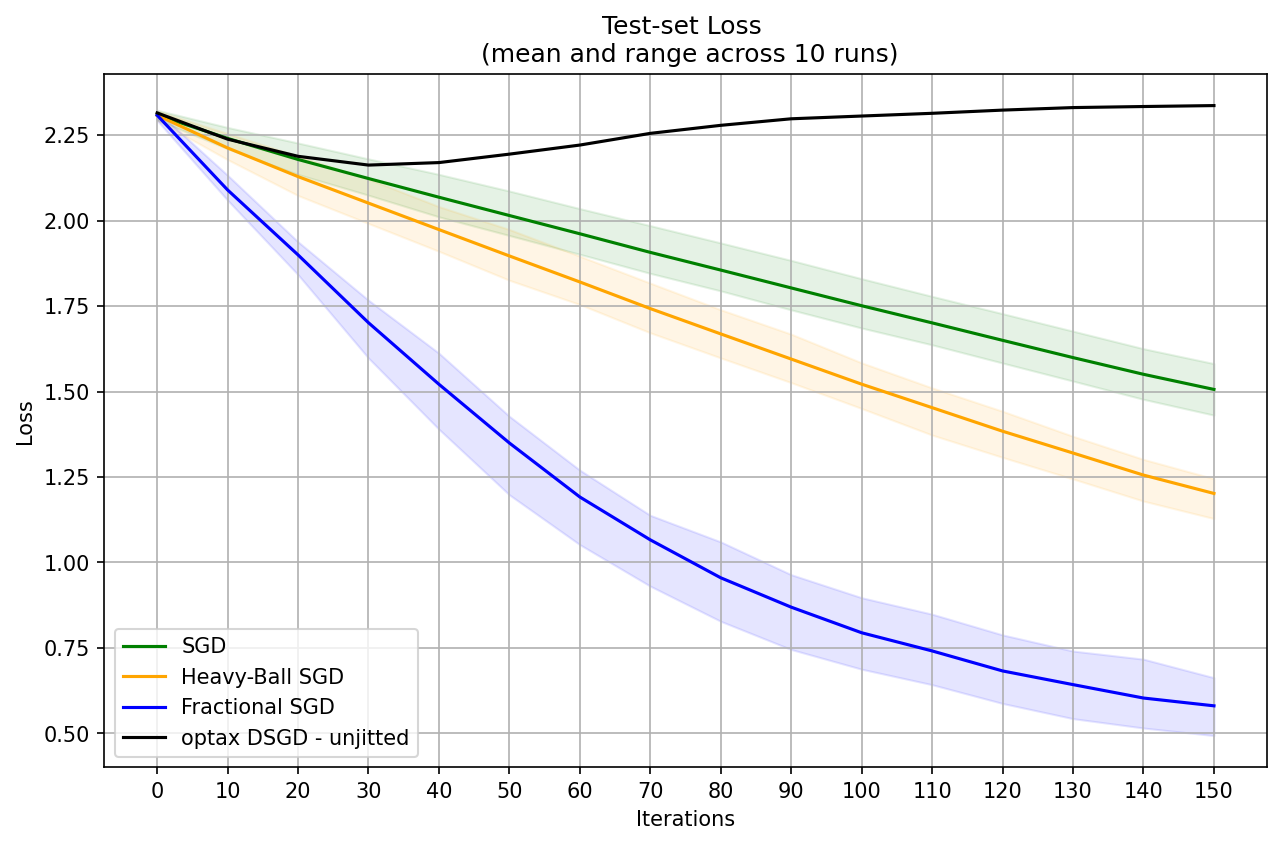

In [36]:
import pickle
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import pickle
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

PATH = "list_test_Loss_acrossInitializations_momentum.pkl"

with open(PATH, "rb") as fp:   # Unpickling
    loss_momentum = pickle.load(fp)

PATH = "list_test_Loss_acrossInitializations_fractional.pkl"

with open(PATH, "rb") as fp:   # Unpickling
    loss_fractional = pickle.load(fp)



PATH = "/home/andrei/Desktop/PROJECT_ELLIS_COMDO/FOLDER_code/list_test_Loss_acrossInitializations_vanillaGD.pkl"

with open(PATH, "rb") as fp:   # Unpickling
    loss_vanillaGD = pickle.load(fp)

# print(jnp.shape(b)) # I want to see shape (10, 16)


# Calculate mean and range across runs for momentum SGD
mean_momentum = np.mean(loss_momentum, axis=0)
min_momentum = np.min(loss_momentum, axis=0)
max_momentum = np.max(loss_momentum, axis=0)

# Calculate mean and range across runs for fractional SGD
mean_fractional = np.mean(loss_fractional, axis=0)
min_fractional = np.min(loss_fractional, axis=0)
max_fractional = np.max(loss_fractional, axis=0)


mean_vanillaGD = np.mean(loss_vanillaGD, axis=0)
min_vanillaGD = np.min(loss_vanillaGD, axis=0)
max_vanillaGD = np.max(loss_vanillaGD, axis=0)


# Plot
plt.figure(figsize=(10, 6), dpi= 150)

# Plot momentum SGD
plt.plot(mean_vanillaGD, label='SGD', color='green')
plt.fill_between(range(len(mean_vanillaGD)), min_vanillaGD, max_vanillaGD, color='green', alpha=0.1)


# Plot momentum SGD
plt.plot(mean_momentum, label='Heavy-Ball SGD', color='orange')
plt.fill_between(range(len(mean_momentum)), min_momentum, max_momentum, color='orange', alpha=0.1)

# Plot fractional SGD
plt.plot(mean_fractional, label='Fractional SGD', color='blue')
plt.fill_between(range(len(mean_fractional)), min_fractional, max_fractional, color='blue', alpha=0.1)

plt.xticks(np.linspace(0, 16-1, 16), np.arange(0, 151, 10))  # Set x-ticks to 0, 10, 20, ..., 150
plt.plot(range(len(mean_momentum)), list_test_Loss_acrossInitializations[0], color = "black", label= "optax DSGD - unjitted")

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Test-set Loss \n (mean and range across 10 runs)')
plt.legend()
plt.grid(True)
plt.show()





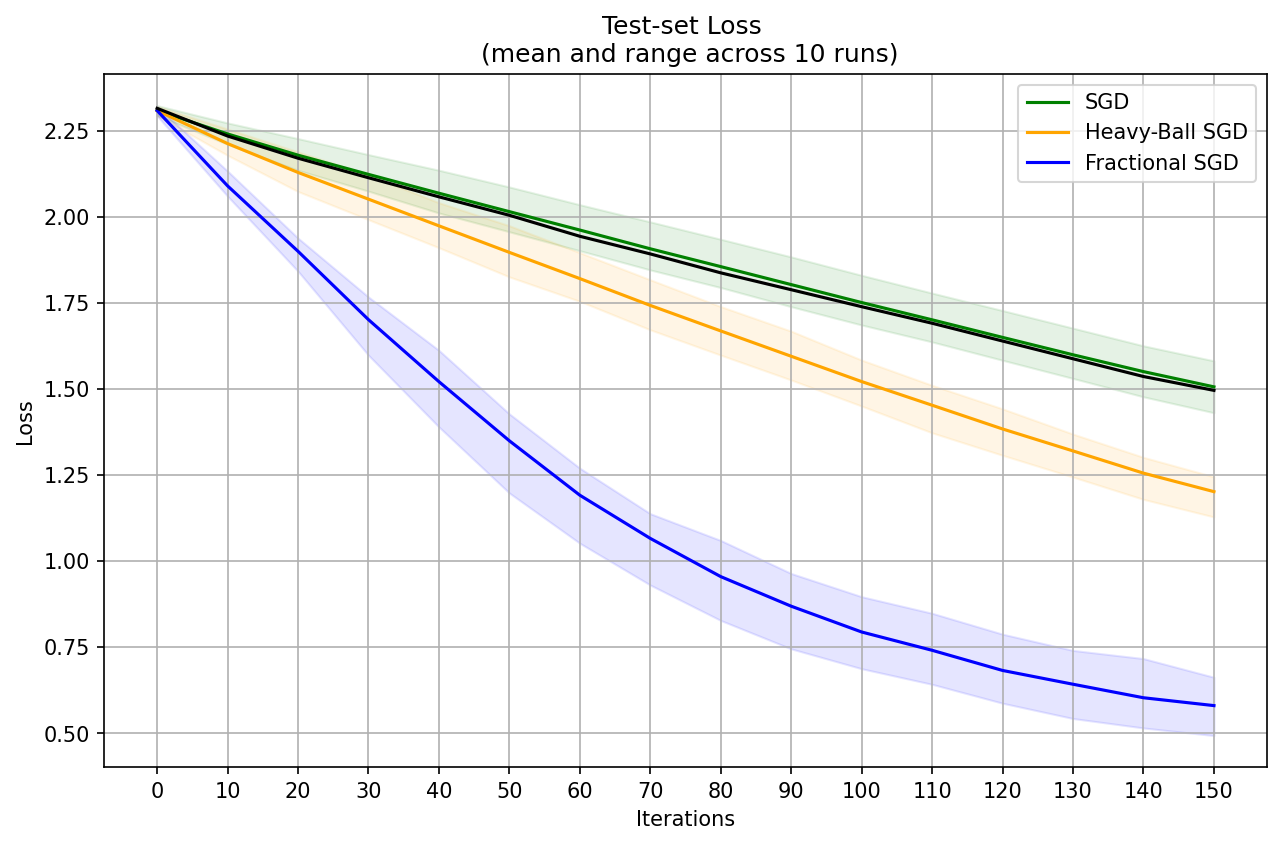

In [34]:
import pickle
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import pickle
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

PATH = "list_test_Loss_acrossInitializations_momentum.pkl"

with open(PATH, "rb") as fp:   # Unpickling
    loss_momentum = pickle.load(fp)

PATH = "list_test_Loss_acrossInitializations_fractional.pkl"

with open(PATH, "rb") as fp:   # Unpickling
    loss_fractional = pickle.load(fp)



PATH = "/home/andrei/Desktop/PROJECT_ELLIS_COMDO/FOLDER_code/list_test_Loss_acrossInitializations_vanillaGD.pkl"

with open(PATH, "rb") as fp:   # Unpickling
    loss_vanillaGD = pickle.load(fp)

# print(jnp.shape(b)) # I want to see shape (10, 16)


# Calculate mean and range across runs for momentum SGD
mean_momentum = np.mean(loss_momentum, axis=0)
min_momentum = np.min(loss_momentum, axis=0)
max_momentum = np.max(loss_momentum, axis=0)

# Calculate mean and range across runs for fractional SGD
mean_fractional = np.mean(loss_fractional, axis=0)
min_fractional = np.min(loss_fractional, axis=0)
max_fractional = np.max(loss_fractional, axis=0)


mean_vanillaGD = np.mean(loss_vanillaGD, axis=0)
min_vanillaGD = np.min(loss_vanillaGD, axis=0)
max_vanillaGD = np.max(loss_vanillaGD, axis=0)


# Plot
plt.figure(figsize=(10, 6), dpi= 150)

# Plot momentum SGD
plt.plot(mean_vanillaGD, label='SGD', color='green')
plt.fill_between(range(len(mean_vanillaGD)), min_vanillaGD, max_vanillaGD, color='green', alpha=0.1)


# Plot momentum SGD
plt.plot(mean_momentum, label='Heavy-Ball SGD', color='orange')
plt.fill_between(range(len(mean_momentum)), min_momentum, max_momentum, color='orange', alpha=0.1)

# Plot fractional SGD
plt.plot(mean_fractional, label='Fractional SGD', color='blue')
plt.fill_between(range(len(mean_fractional)), min_fractional, max_fractional, color='blue', alpha=0.1)

plt.xticks(np.linspace(0, 16-1, 16), np.arange(0, 151, 10))  # Set x-ticks to 0, 10, 20, ..., 150

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Test-set Loss \n (mean and range across 10 runs)')
plt.legend()
plt.grid(True)
plt.plot(range(len(mean_momentum)), list_test_Loss_acrossInitializations_mySGD[0], color = "black", label= "optax DSGD")
plt.show()


## Your previous runs don't have consensus jump
 -> do 3 runs of your imlementation of SGD and consensus jump

In [18]:
# Hyperparameters


BATCH_SIZE = 64

LEARNING_RATE = 0.005

STEPS = 150

PRINT_EVERY = 10



normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

# ____________________ splitting MNIST into 2 distinct datasets __________________
import os
os.chdir("/home/andrei/Desktop/PROJECT_ELLIS_COMDO/FOLDER_code")

from comdo.utils_ANNs import get_2DO_datasets


Agent1_Train_dataset, Agent1_Test_dataset, Agent2_Train_dataset, Agent2_Test_dataset = \
    get_2DO_datasets(train_dataset= train_dataset, test_dataset= test_dataset)


trainloader_Agent1 = torch.utils.data.DataLoader(
    Agent1_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader_Agent1 = torch.utils.data.DataLoader(
    Agent1_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

trainloader_Agent2 = torch.utils.data.DataLoader(
    Agent2_Train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader_Agent2 = torch.utils.data.DataLoader(
    Agent2_Test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

# ________________________ train script __________________-

from comdo.utils_ANNs import DOptimizer

def train(
    optimizer,
    models: CNN,
    trainloader_Agent1: torch.utils.data.DataLoader,
    trainloader_Agent2: torch.utils.data.DataLoader,
    testloader_Agent1: torch.utils.data.DataLoader,
    testloader_Agent2: torch.utils.data.DataLoader,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    # opt_state = optim.init(eqx.filter(model, eqx.is_array))



    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.


    # @eqx.filter_jit
    def make_step(
        models: CNN,
        x_agent1: Float[Array, "batch 1 28 28"],
        y_agent1: Int[Array, " batch"],
        x_agent2: Float[Array, "batch 1 28 28"],
        y_agent2: Int[Array, " batch"],

    ):

        # making list with the grads (pytrees) of th etwo agents
        grads_list = []
        grads_list.append(eqx.filter_value_and_grad(loss)(models[0], x_agent1, y_agent1)[1])
        grads_list.append(eqx.filter_value_and_grad(loss)(models[1], x_agent2, y_agent2)[1])

        # loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        # updates, opt_state = optim.update(grads, opt_state, model)

        # model = eqx.apply_updates(model, updates)
        
        models = optimizer.step_withMemory(models, grads_list)

        return models
    
    # Loop over our training dataset as many times as we need.
    def infinite_trainloader_agent1():
        while True:
            yield from trainloader_Agent1

    def infinite_trainloader_agent2():
        while True: 
            yield from trainloader_Agent2


    writer = SummaryWriter()

    list_test_accuracy = []
    list_test_loss =[]

    for step, (x_agent1, y_agent1), (x_agent2, y_agent2) in zip(range(steps), infinite_trainloader_agent1(), infinite_trainloader_agent2()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x_agent1 = x_agent1.numpy()
        y_agent1 = y_agent1.numpy()

        x_agent2 = x_agent2.numpy()
        y_agent2 = y_agent2.numpy()
        
        # start = time.time()


        models = make_step(models, x_agent1, y_agent1, x_agent2, y_agent2)
            
        # print("Made step ", step )
        # print("Seconds to take this step: ", time.time() - start)

        # print("Z_g")
        # print(optimizer.z_g)

        if (step % print_every) == 0 or (step == steps - 1):

            test_loss = 0
            test_accuracy = 0
            train_loss = 0
            train_accuracy = 0

            # start = time.time()

            test_loss +=  float(evaluate(models[0], testloader_Agent1)[0])
            test_accuracy +=  float(evaluate(models[0], testloader_Agent1)[1])
            
            test_loss += float(evaluate(models[1], testloader_Agent2)[0])
            test_accuracy += float(evaluate(models[1], testloader_Agent2)[1])

            train_loss +=  float(evaluate(models[0], trainloader_Agent1)[0])
            train_accuracy += float(evaluate(models[0], trainloader_Agent1)[1])
            train_loss += float(evaluate(models[1], trainloader_Agent2)[0])
            train_accuracy += float(evaluate(models[1], trainloader_Agent2)[1])


            # print("Seconds to compute loss and accuracy: ", time.time() - start)

            # start = time.time()

            writer.add_scalar("global train loss", train_loss/2, step)   # printing means
            writer.add_scalar("global test loss", test_loss/2, step)

            writer.add_scalar("global train accuracy", train_accuracy/2, step)
            writer.add_scalar("global test accuracy", test_accuracy/2, step)

            # ______ appending performance to lists ______________-

            list_test_accuracy.append(test_accuracy/2) 
            list_test_loss.append(test_loss/2)


            # if (step % print_every) == 0 or (step == steps - 1):
            print(
                f"global train_loss={train_loss/2}, gloabal train_accuracy={train_accuracy/2} "
                f"global test_loss={test_loss/2}, global test_accuracy={test_accuracy/2}" )
            
            # print("Seconds to write and print: ", time.time() - start)

    list_test_Accuracies_acrossInitializations.append(list_test_accuracy)
    list_test_Loss_acrossInitializations_mySGD.append(list_test_loss)

    return models


SEEDS = range(3)

# for algorithm in ["momentum", "fractional", "vanillaGD"]:

for algorithm in ["vanillaGD"]:

    list_test_Accuracies_acrossInitializations = []
    list_test_Loss_acrossInitializations_mySGD = []

    for SEED in SEEDS:

        key = jax.random.PRNGKey(SEED)
        key, subkey = jax.random.split(key, 2)

        agent1 = CNN(subkey)
        agent2 = CNN(subkey)

        models = [agent1, agent2]

        # if algorithm == "fractional":
        #     optimizer_fractional = comdo.utils_ANNs.DOptimizer(models= models,
        #                                             beta_c = LEARNING_RATE,
        #                                             beta_g = LEARNING_RATE,
        #                                             beta_gm = LEARNING_RATE / 2)                                        

        #     trained_models = train(optimizer= optimizer_fractional, models= models, trainloader_Agent1= trainloader_Agent1, trainloader_Agent2= trainloader_Agent2, testloader_Agent1= testloader_Agent1, testloader_Agent2= testloader_Agent2, steps= STEPS, print_every= PRINT_EVERY)

        #     with open('LastRun_list_test_Accuracies_acrossInitializations_fractional.pkl', 'wb') as f:
        #         pickle.dump(list_test_Accuracies_acrossInitializations, f)

        #     with open('LastRunlist_test_Loss_acrossInitializations_mySGD_fractional.pkl', 'wb') as f:
        #         pickle.dump(list_test_Loss_acrossInitializations_mySGD, f)


        if algorithm == "vanillaGD":
            optimizer_vanillaGD = comdo.utils_ANNs.DOptimizer(models= models,  
                                                    beta_g = LEARNING_RATE,  # removed beta_c such that defaults to consensus jump
                                                    beta_gm = 0,
                                                    len_memory = 1)                                        

            trained_models = train(optimizer= optimizer_vanillaGD, models= models, trainloader_Agent1= trainloader_Agent1, trainloader_Agent2= trainloader_Agent2, testloader_Agent1= testloader_Agent1, testloader_Agent2= testloader_Agent2, steps= STEPS, print_every= PRINT_EVERY)

            # with open('list_test_Accuracies_acrossInitializations_vanillaGD.pkl', 'wb') as f:
            #     pickle.dump(list_test_Accuracies_acrossInitializations, f)

            # with open('list_test_Loss_acrossInitializations_mySGD_vanillaGD.pkl', 'wb') as f:
            #     pickle.dump(list_test_Loss_acrossInitializations_mySGD, f)
       
        # if algorithm == "momentum":
        #     optimizer_momentum = comdo.utils_ANNs.DOptimizer(models= models,
        #                                             beta_c = LEARNING_RATE,
        #                                             beta_g = LEARNING_RATE,
        #                                             beta_gm = LEARNING_RATE / 2,
        #                                             len_memory = 1)                                        

        #     trained_models = train(optimizer= optimizer_momentum, models= models, trainloader_Agent1= trainloader_Agent1, trainloader_Agent2= trainloader_Agent2, testloader_Agent1= testloader_Agent1, testloader_Agent2= testloader_Agent2, steps= STEPS, print_every= PRINT_EVERY)

        #     with open('list_test_Accuracies_acrossInitializations_momentum.pkl', 'wb') as f:
        #         pickle.dump(list_test_Accuracies_acrossInitializations, f)

        #     with open('list_test_Loss_acrossInitializations_mySGD_momentum.pkl', 'wb') as f:
        #         pickle.dump(list_test_Loss_acrossInitializations_mySGD, f)


global train_loss=2.3173412084579468, gloabal train_accuracy=0.10105830803513527 global test_loss=2.315000534057617, global test_accuracy=0.09918908402323723
global train_loss=2.2397671937942505, gloabal train_accuracy=0.2347993552684784 global test_loss=2.234581232070923, global test_accuracy=0.24050632864236832
global train_loss=2.1777141094207764, gloabal train_accuracy=0.37192402780056 global test_loss=2.1701585054397583, global test_accuracy=0.3856803923845291
global train_loss=2.1204824447631836, gloabal train_accuracy=0.44104889035224915 global test_loss=2.1134047508239746, global test_accuracy=0.45164160430431366
global train_loss=2.0670918226242065, gloabal train_accuracy=0.503777265548706 global test_loss=2.0580413341522217, global test_accuracy=0.5197784900665283
global train_loss=2.0137393474578857, gloabal train_accuracy=0.5666586458683014 global test_loss=2.0043715238571167, global test_accuracy=0.581190675497055
global train_loss=1.9566857814788818, gloabal train_accurac

KeyboardInterrupt: 